In [1]:
from glob import glob

import nd2
from natsort import natsorted

# make local editable packages automatically reload
%load_ext autoreload
%autoreload 2

# Import dependencies
import numpy as np

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = False #core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')
%matplotlib inline


>>> GPU activated? 0


In [2]:
SB8_ND2s = natsorted(glob("FDAAs_images/SB8_all_small*.nd2"))

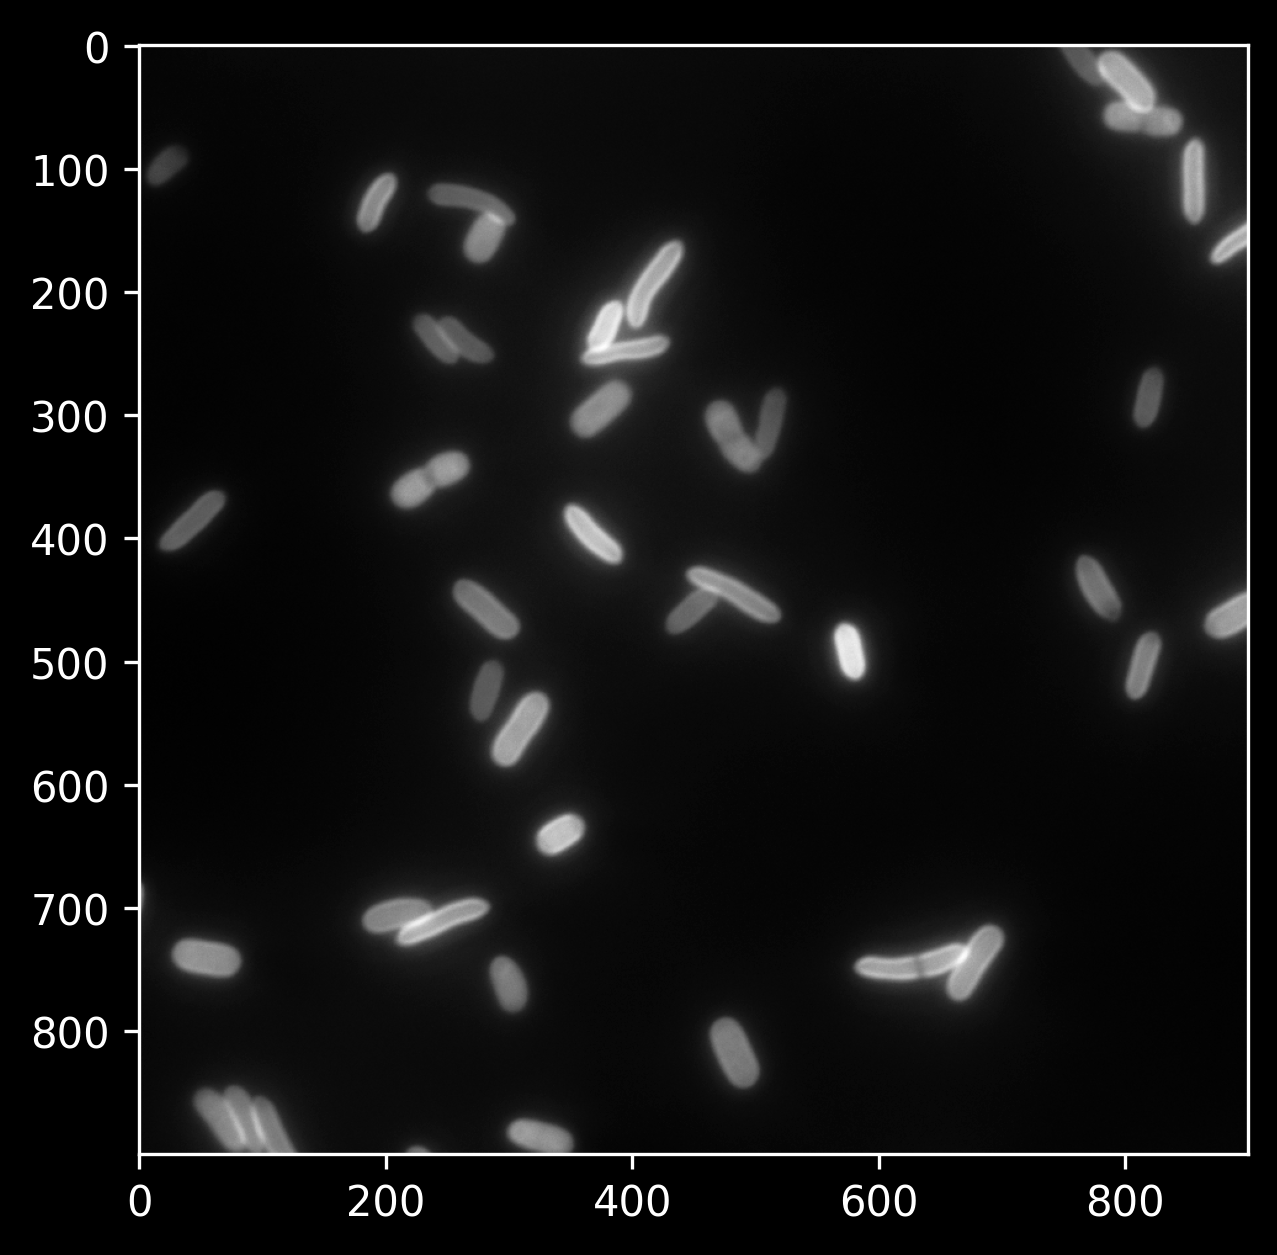

In [9]:
### for poster

files = ["FDAAs_images/SB8_all_small021.nd2", "FDAAs_images/SB8_all_small023.nd2", "FDAAs_images/SB8_all_small025.nd2"]
a = np.concatenate([nd2.imread(file) for file in files], axis=2)

plt.imshow(a[3][:900,:900], cmap="Greys_r")
plt.show()


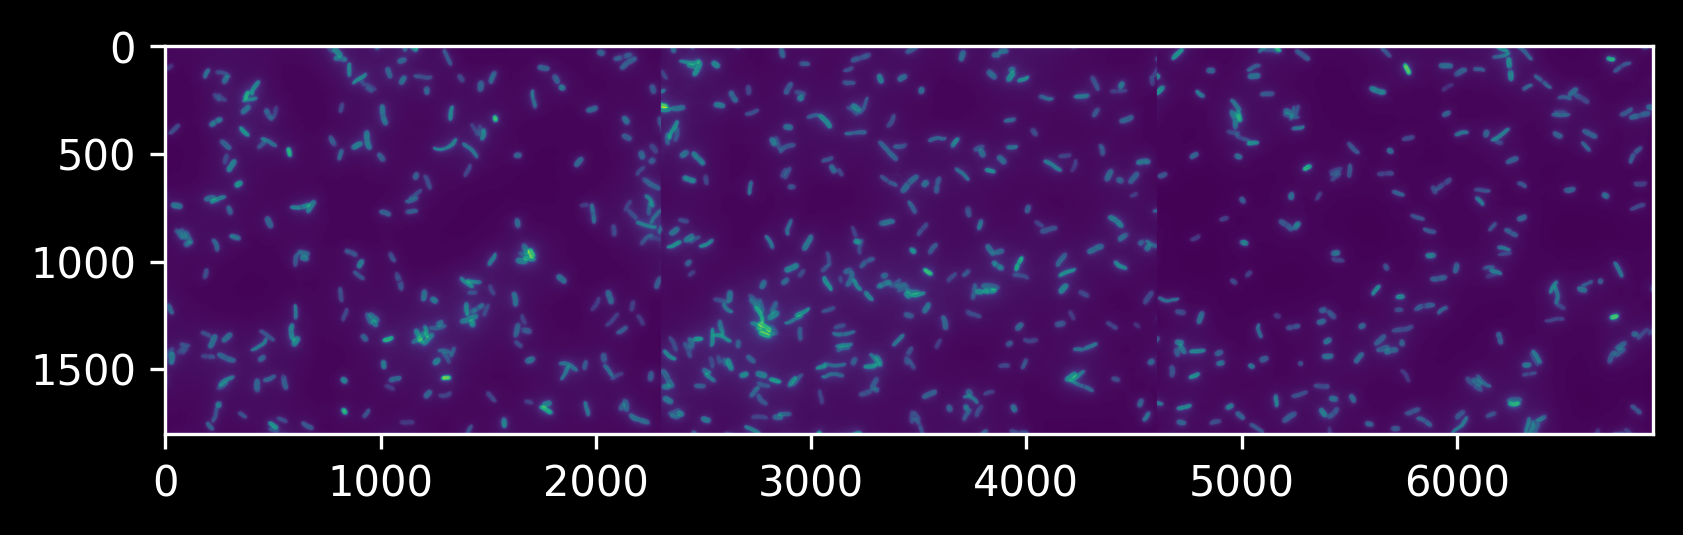

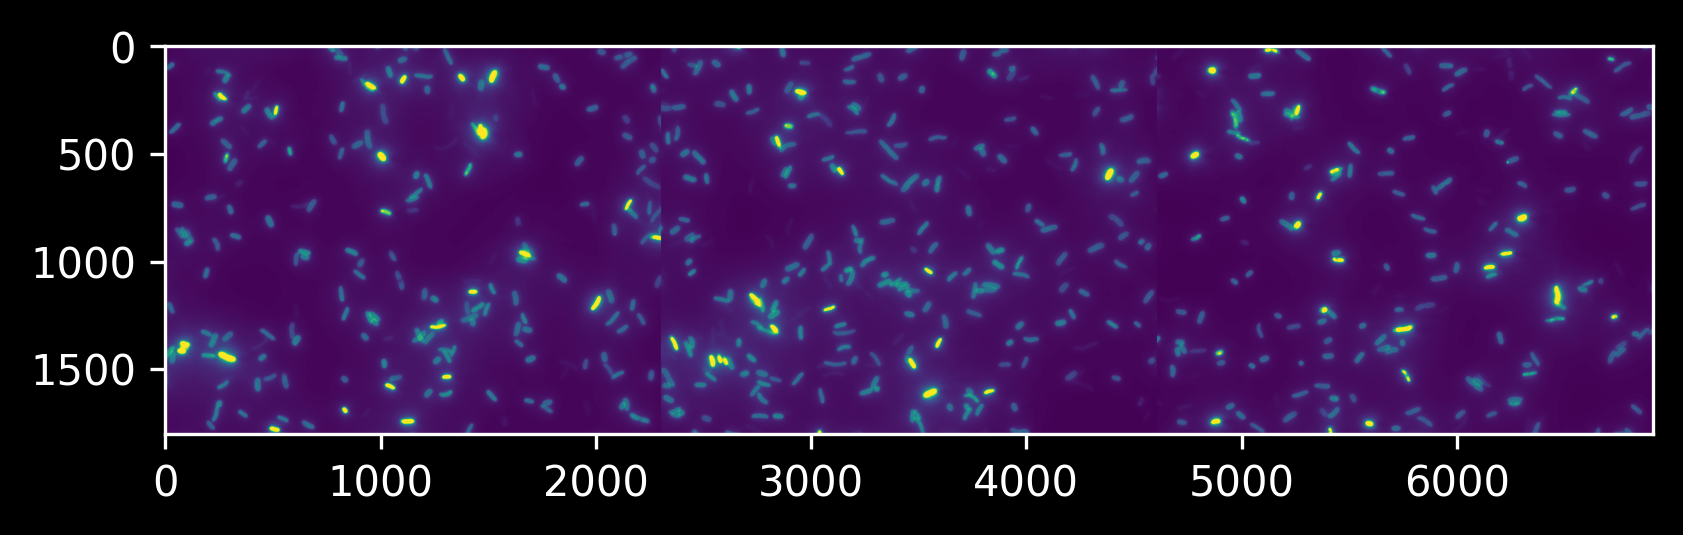

In [3]:
files = ["FDAAs_images/SB8_all_small021.nd2", "FDAAs_images/SB8_all_small023.nd2", "FDAAs_images/SB8_all_small025.nd2"]
a = np.concatenate([nd2.imread(file) for file in files], axis=2)

plt.imshow(a[3])
plt.show()
plt.imshow(a[1])

In [4]:
a.shape

(4, 1800, 6912)

In [5]:
from cellpose_omni import transforms
from omnipose.utils import normalize99
imgs = [a[-1]]

# print some info about the images.
for i in imgs:
    print('Original image shape:',i.shape)
    print('data type:',i.dtype)
    print('data range:', i.min(),i.max())
nimg = len(imgs)
print('number of images:',nimg)

fig = plt.figure(figsize=[40]*2,frameon=False) # initialize figure
print('new shape:')
for k in range(len(imgs)):
    img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
    if len(img.shape)>2:
        # imgs[k] = img[:,:,1] # could pick out a specific channel
        imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale 
        
    imgs[k] = normalize99(imgs[k])

Original image shape: (1800, 6912)
data type: uint16
data range: 625 42950
number of images: 1
new shape:


<Figure size 12000x12000 with 0 Axes>

In [7]:
from cellpose_omni import models

In [8]:
model_name = 'bact_fluor_omni'
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)

2023-05-11 02:01:10,552 [INFO] >>bact_fluor_omni<< model set to be used
2023-05-11 02:01:10,567 [INFO] >>>> using CPU


In [9]:
chans = [0,0] #this means segment based on first channel, no second channel 

n = [-3] # make a list of integers to select which images you want to segment
n = range(nimg) # or just segment them all 

# define parameters
mask_threshold = -1
verbose = 0 # turn on if you want to see more output 
use_gpu = use_GPU #defined above
transparency = True # transparency in flow output
rescale=None # give this a number if you need to upscale or downscale your images
omni = True # we can turn off Omnipose mask reconstruction, not advised 
flow_threshold = 0 # default is .4, but only needed if there are spurious masks to clean up; slows down output
niter = None # None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation 
resample = True #whether or not to run dynamics on rescaled grid or original grid 
cluster = True # use DBSCAN clustering
augment = False # average the outputs from flipped (augmented) images; slower, usually not needed 
tile = False # break up image into smaller parts then stitch together
affinity_seg = 1 #new feature, stay tuned...

masks, flows, styles = model.eval([imgs[i] for i in n],
                                  channels=chans,
                                  rescale=rescale,
                                  mask_threshold=mask_threshold,
                                  transparency=transparency,
                                  flow_threshold=flow_threshold,
                                  niter=niter,
                                  omni=omni,
                                  cluster=cluster, 
                                  resample=resample,
                                  verbose=verbose, 
                                  affinity_seg=affinity_seg,
                                  tile=tile,
                                  augment=augment)

4 -color algorthm failed,trying again with 5 colors. Depth 0


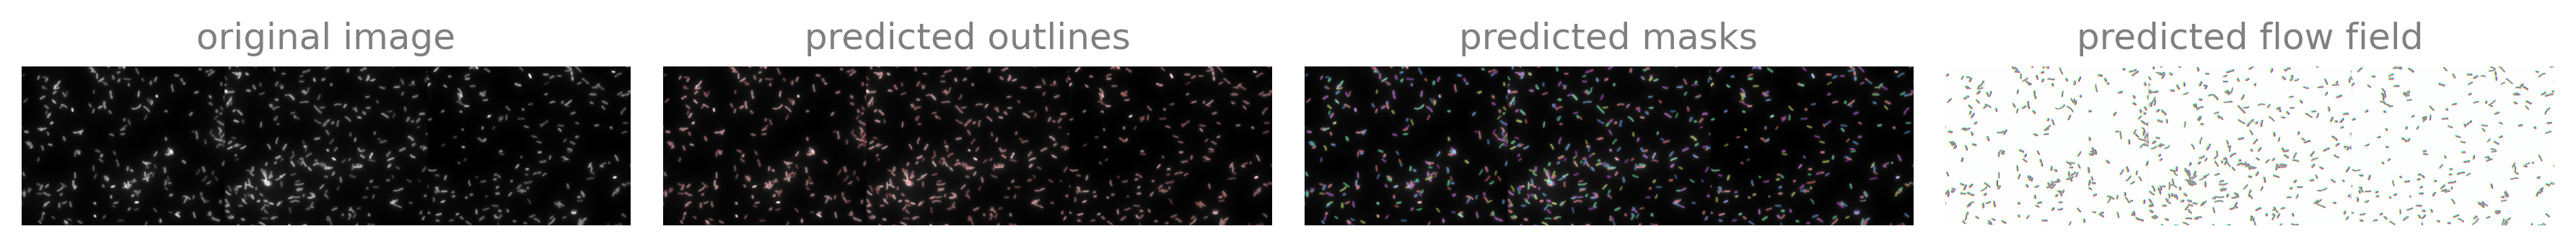

In [10]:
from cellpose_omni import plot
import omnipose

for idx,i in enumerate(n):

    maski = masks[idx] # get masks
    bdi = flows[idx][-1] # get boundaries
    flowi = flows[idx][0] # get RGB flows 

    fig = plt.figure(figsize=(12,5),frameon=False)
    plot.show_segmentation(fig, omnipose.utils.normalize99(imgs[i]), 
                           maski, flowi, bdi, channels=chans, omni=True, bg_color=0)

    plt.tight_layout()
    plt.show()

In [33]:
interpeak_distances

,idx,RADA,HADA,Average width,RADA - HADA
1,20,8,10,9.0,-2
2,27,14,18,16.0,-4
3,29,14,17,15.5,-3
5,39,15,18,16.5,-3
7,41,16,18,17.0,-2
...,...,...,...,...,...
199,800,11,14,12.5,-3
200,801,10,11,10.5,-1
201,805,8,11,9.5,-3
202,812,8,10,9.0,-2


<AxesSubplot:xlabel='HADA', ylabel='RADA - HADA'>

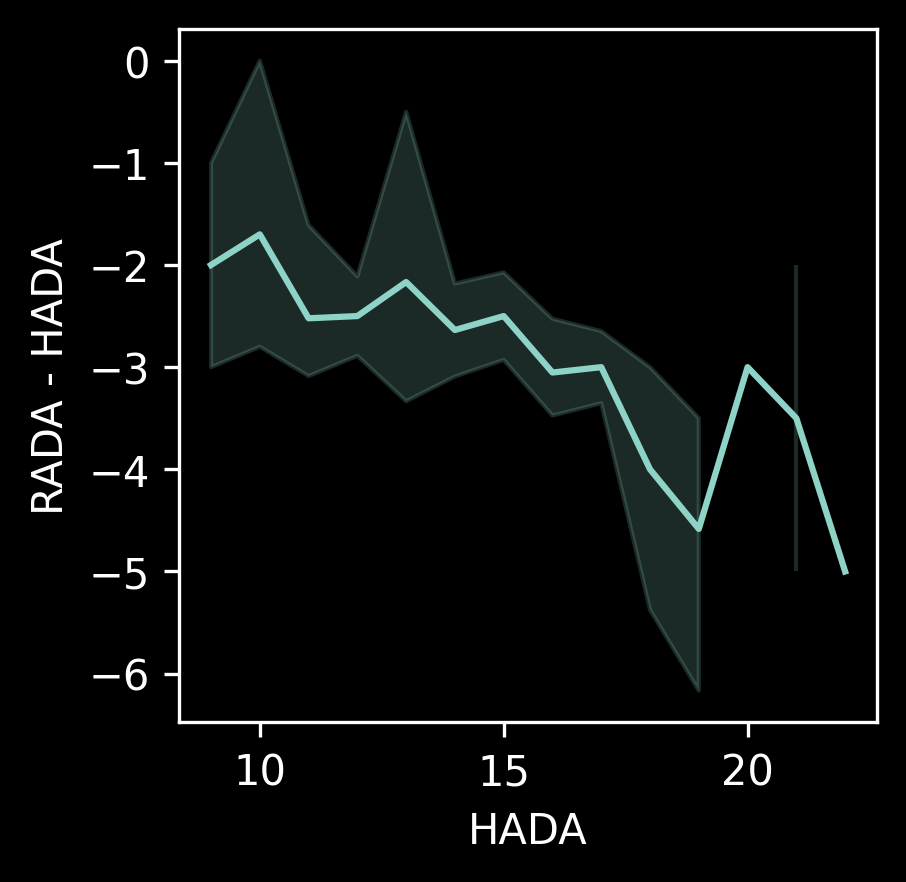

In [35]:
plt.figure(figsize=(3,3))
sns.lineplot(data = interpeak_distances, x = "HADA", y = "RADA - HADA")

In [27]:
interpeak_melt = interpeak_distances.melt()

In [28]:
interpeak_melt = interpeak_melt[interpeak_melt["variable"].isin(["RADA", "HADA"])]

In [29]:
import scipy
stat, pvalue = scipy.stats.ttest_ind(interpeak_distances["RADA"], interpeak_distances["HADA"])
pvalue

1.3836545888156576e-15

In [30]:
interpeak_distances["RADA"].mean() - interpeak_distances["HADA"].mean()

-2.9150326797385624

In [31]:
interpeak_melt["value"] *= 0.0655/1.5

Text(0, 0.5, 'Width ($\\mu$m)')

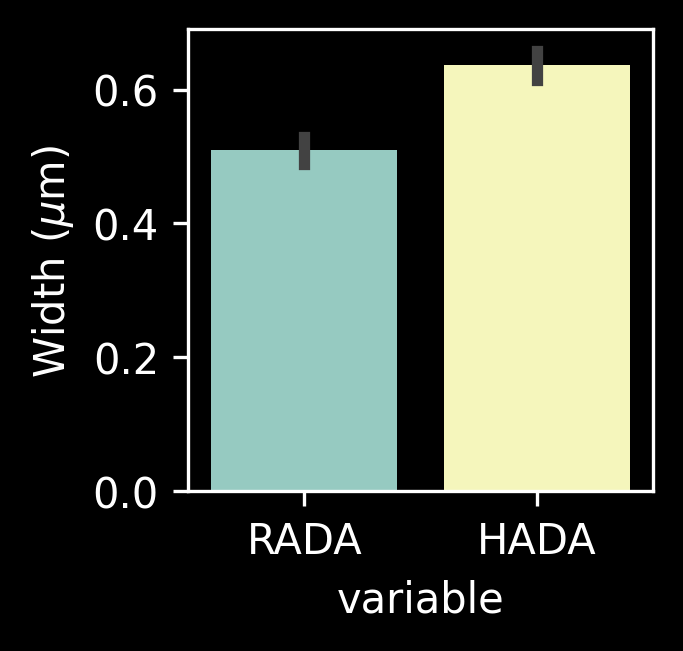

In [32]:
plt.figure(figsize=(2,2))
sns.barplot(data=interpeak_melt, y = "value", x = "variable")
plt.ylabel("Width ($\mu$m)")

<AxesSubplot:xlabel='RADA - HADA', ylabel='Count'>

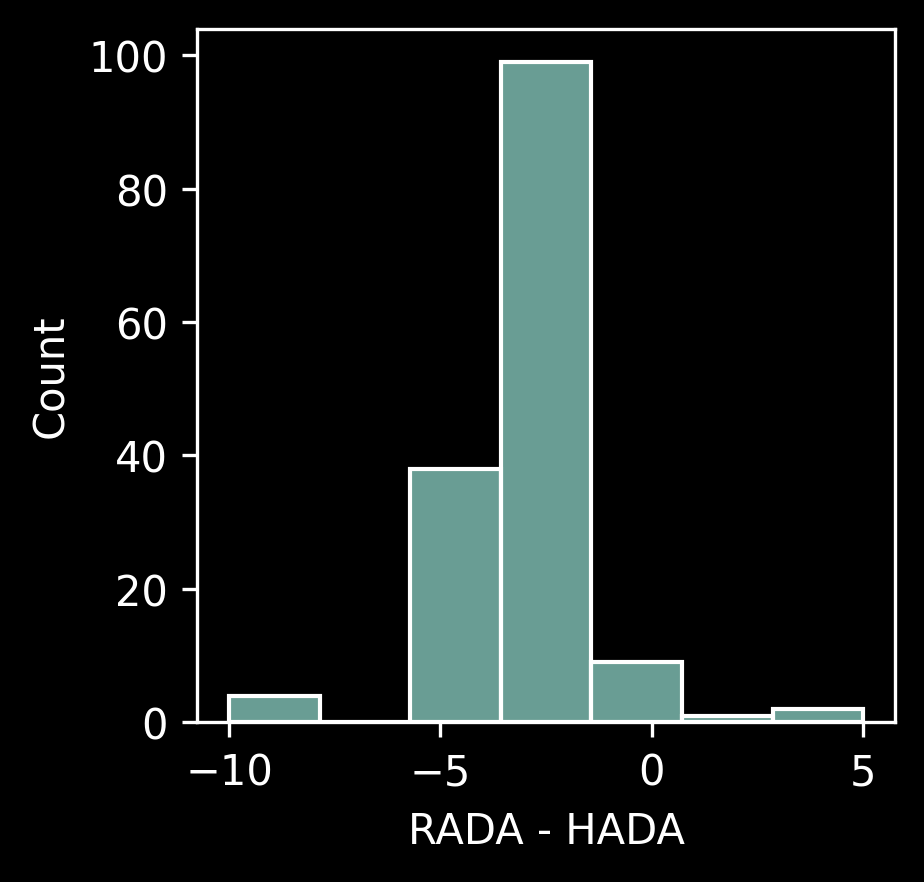

In [125]:
plt.figure(figsize=(3,3))
sns.histplot(data = interpeak_distances, x = "RADA - HADA", bins = 7)

In [ ]:
sns.barplot(